# ECS736P - INFORMATION RETRIEVAL 2021/22
**<ins>Contents</ins>**

- Section 1: Pre-processing
    - Section 1.1: Importing packages
    - Section 1.2: Loading dataset
    - Section 1.3: Loading additional features
- Section 2: Statistics
    - Section 2.3: Feature statistics
- Section 3: Indexing & Retrieval Framework
    - Section 3.1: Indexing framework
    - Section 3.2: TF/IDF Model
    - Section 3.3: BM25 Model
- Section 4: Ranking framework
    - Section 4.1: Query formulation
    - Section 4.2: Document ranking
- Section 5: Results
    - Section 5.1: Evaluation metrics

#### <ins>Section 1.1: Importing packages</ins>

In [1]:
!pip install lxml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

#### <ins>Section 1.2: Loading dataset</ins>

In [2]:
df = pd.read_csv('covid_abstracts.csv')
df = df[:1000]
df

,title,abstract,url
0,Real-World Experience with COVID-19 Including...,This article summarizes the experiences of COV...,https://pubmed.ncbi.nlm.nih.gov/35008137
1,Successful outcome of pre-engraftment COVID-19...,Coronavirus disease 2019 COVID-19 caused by...,https://pubmed.ncbi.nlm.nih.gov/35008104
2,The impact of COVID-19 on oncology professiona...,BACKGROUND COVID-19 has had a significant imp...,https://pubmed.ncbi.nlm.nih.gov/35007996
3,ICU admission and mortality classifiers for CO...,The coronavirus disease 2019 COVID-19 which ...,https://pubmed.ncbi.nlm.nih.gov/35007991
4,Clinical evaluation of nasopharyngeal midturb...,In the setting of supply chain shortages of na...,https://pubmed.ncbi.nlm.nih.gov/35007959
...,...,...,...
995,Feasibility of Using a Mobile App for Stress i...,BACKGROUND Middle-aged adults 40 to 65 years...,https://pubmed.ncbi.nlm.nih.gov/34989677
996,Obatoclax inhibits SARS-CoV-2 entry by altered...,Coronavirus disease 2019 COVID-19 caused by ...,https://pubmed.ncbi.nlm.nih.gov/34989664
997,The societal economic value of COVID-19 vaccin...,AIMS The COVID-19 pandemic has claimed the li...,https://pubmed.ncbi.nlm.nih.gov/34989654
998,The use of tele-audiology in ototoxicity monit...,INTRODUCTION Due to the growing burden of dis...,https://pubmed.ncbi.nlm.nih.gov/34989631


#### <ins>Section 1.3: Loading additional features</ins>

In [3]:
df['Authors'] = np.NaN
df['Authors'] = df['Authors'].astype('object')
df['Year'] = np.NaN

In [4]:
def extract_authors(bs4):
    authors = []
    all_links = bs4.find_all("a")
    for link in all_links:
            if link.get("data-ga-label") != None and link.get("data-ga-action") == "author_link":
                authors.append(link.get("data-ga-label"))
    return authors

def extract_year(bs4):
    citation = soup.find(class_="cit").text # this contains the citation string
    year = citation[:4] # this contains the first 4 characters in the string, which is the year of publication
    return year

n=0
for x in tqdm(df.url):
    try:    
        html = urlopen(x)
        soup = BeautifulSoup(html,"lxml")
        df.at[n, 'Authors'] = extract_authors(soup)
        df.at[n, 'Year'] = extract_year(soup)
        #df.at[n, 'Authors'] = authors
        n = n+1
        continue
    except:
        df.drop([0, n])
        n = n+1
        continue
df.to_csv("covid_abstracts.csv")

100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


In [5]:
display(df.head())

,title,abstract,url,Authors,Year
0,Real-World Experience with COVID-19 Including...,This article summarizes the experiences of COV...,https://pubmed.ncbi.nlm.nih.gov/35008137,"[Sylvia Anderson, Kelly Baloun, Benjamin Loewe...",2021.0
1,Successful outcome of pre-engraftment COVID-19...,Coronavirus disease 2019 COVID-19 caused by...,https://pubmed.ncbi.nlm.nih.gov/35008104,"[Hoda Pourhassan, Corinna La Rosa, Flavia Chiu...",2022.0
2,The impact of COVID-19 on oncology professiona...,BACKGROUND COVID-19 has had a significant imp...,https://pubmed.ncbi.nlm.nih.gov/35007996,"[K H J Lim, K Murali, E Thorne, K Punie, K Kam...",2022.0
3,ICU admission and mortality classifiers for CO...,The coronavirus disease 2019 COVID-19 which ...,https://pubmed.ncbi.nlm.nih.gov/35007991,"[Vasileios C Pezoulas, Konstantina D Kourou, E...",2022.0
4,Clinical evaluation of nasopharyngeal midturb...,In the setting of supply chain shortages of na...,https://pubmed.ncbi.nlm.nih.gov/35007959,"[Byron M Berenger, Kevin Fonseca, Angela R Sch...",2022.0


#### <ins>Section 2.1: Feature statistics</ins>

In [6]:
len_abstract = []
for x in df.abstract:
    len_abstract.append(len(x))
df['abstract_length'] = len_abstract

len_title = []
for x in df.title:
    len_title.append(len(x))
df['title_length'] = len_title
df.describe()

,Year,abstract_length,title_length
count,492.000000,1000.000000,1000.000000
mean,2021.662602,1562.537000,108.674000
std,0.494351,539.121514,35.167492
min,2020.000000,254.000000,19.000000
25%,2021.000000,1199.750000,85.000000
50%,2022.000000,1571.000000,107.000000
75%,2022.000000,1869.500000,130.000000
max,2022.000000,4444.000000,240.000000


In [7]:
df.count()

title              1000
abstract           1000
url                1000
Authors             515
Year                492
abstract_length    1000
title_length       1000
dtype: int64

Text(0, 0.5, 'Count')

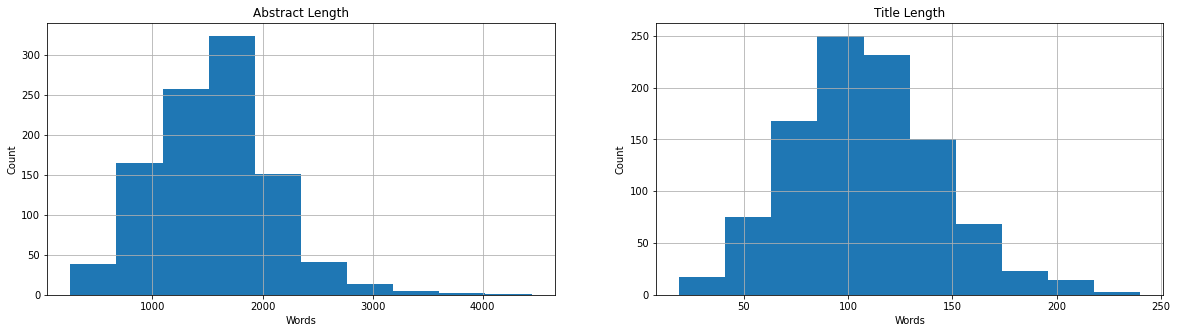

In [8]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(20,5))
df['abstract_length'].hist(ax=a1, bins=10)
a1.set_title('Abstract Length')
a1.set_xlabel('Words')
a1.set_ylabel('Count')
df['title_length'].hist(ax=a2, bins=10)
a2.set_title('Title Length')
a2.set_xlabel('Words')
a2.set_ylabel('Count')

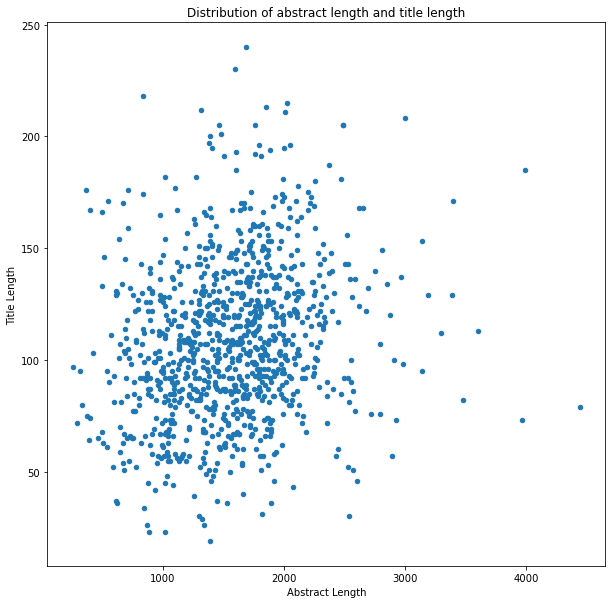

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
df.plot(kind='scatter', x='abstract_length', y='title_length', ax=ax, logx=False, logy=False)
_ = ax.set_title('Distribution of abstract length and title length')
_ = ax.set_xlabel('Abstract Length')
_ = ax.set_ylabel('Title Length')

#### <ins>Section 3.1: Indexing framework</ins>

In [10]:
df = pd.read_csv('covid_abstracts.csv')

In [11]:
df = df[:100]

In [12]:
df1=df.title
df2=df.abstract
df3= df2.str.lower()
df_list = df3.values.tolist()
document_terms = [doc.split(' ') for doc in df_list]

vectorizer = CountVectorizer(stop_words='english')
documents_vectorized = vectorizer.fit_transform(df_list)
vocabulary = vectorizer.get_feature_names_out()

dataframe = pd.DataFrame(documents_vectorized.toarray(), columns=vocabulary)

#### <ins>Section 3.2: TF/IDF Model</ins>

In [13]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_documents_vectorized = tfidf_vectorizer.fit_transform(df_list)
tfidf_vocabulary = tfidf_vectorizer.get_feature_names_out()
tfidf_dataframe = pd.DataFrame(tfidf_documents_vectorized.toarray(), columns=tfidf_vocabulary)

In [14]:
def TF_IDF_df(df):
    dfs = (df > 0).sum(axis=0)
    N = df.shape[0]
    idfs = np.log(N/dfs)
    TF_IDF_score = np.array(idfs*df)
    return pd.DataFrame(TF_IDF_score, columns=tfidf_vocabulary)

#TF/IDF model
tf_idf_df = TF_IDF_df(tfidf_dataframe)
display(tf_idf_df[:5])

,00,000,0001,0005,0006,0007,001,003,0035,004,...,yes,yielded,yielding,young,younger,youth,zero,zinc,zno,zoster
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.570716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.309311,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### <ins>Section 3.3: BM25 Model</ins>

In [15]:
def BM25_IDF_df(df, k, b):
    
    dfs = (df > 0).sum(axis=0)
    N = df.shape[0]
    idfs = -np.log(dfs / N)

    k_1 = k
    b = b
    dls = df.sum(axis=1) 
    avgdl = np.mean(dls)

    numerator = np.array((k_1 + 1) * df)
    denominator = np.array(k_1 *((1 - b) + b * (dls / avgdl))).reshape(N,1) + np.array(df)

    BM25_tf = numerator / denominator

    idfs = np.array(idfs)

    BM25_score = BM25_tf * idfs
    return pd.DataFrame(BM25_score, columns=vocabulary)

In [16]:
#Default model
bm25_df = BM25_IDF_df(dataframe, k=1.2, b=0.75) # a dataframe with BM25-idf weights
display(bm25_df[:5])

#Specific model
bm25_df_specific = BM25_IDF_df(dataframe, k=1, b=0.5) # a dataframe with BM25-idf weights
display(bm25_df_specific[:5])

,00,000,0001,0005,0006,0007,001,003,0035,004,...,yes,yielded,yielding,young,younger,youth,zero,zinc,zno,zoster
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,5.670567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.075478,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,00,000,0001,0005,0006,0007,001,003,0035,004,...,yes,yielded,yielding,young,younger,youth,zero,zinc,zno,zoster
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,5.743182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.266312,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### <ins>Section 4.1: Query Formulation</ins>

In [17]:
queries = dict(enumerate([
    'virus',
    'respiratory',
]))

In [18]:
qrels = [
         (0, 0, 1),
         (0,1,1),
         (0,2,0),
         (0,3,1),
         (0,5,0),
         (0,7,1),
         (0,8,1),
         (0,9,0),
         (1, 1, 1),
         (1, 3, 1),
         (1, 8, 1),
         (1, 10, 1),
         (1, 2, 0),
         (1, 7, 0),
         (1, 11, 0),
         (1, 9, 0),
        ]

#### <ins>Section 4.2: Ranking documents</ins>

In [19]:
def retrieve_ranking(query, dfa):
    q_terms = query.split(' ')
    q_terms_only = dfa[q_terms]
    score_q_d = q_terms_only.sum(axis=1)
    return sorted(zip(dfa.index.values,score_q_d.values), key = lambda tup:tup[1], reverse=True)

In [20]:
def precision_at_k(query_id, k, dfa):
    doc_ranking = retrieve_ranking(queries[query_id], dfa)
    retrieved = [doc[0] for doc in doc_ranking[:k]]
    TP = np.array([int((query_id, doc, 1) in qrels) for doc in retrieved]).sum()
    FP = np.array([int((query_id, doc, 0) in qrels) for doc in retrieved]).sum()
    precision = TP / (TP+FP)
    return TP, FP, precision

In [21]:
def f1_score_at_k(query_id, k, dfa):
    doc_ranking = retrieve_ranking(queries[query_id], dfa)
    retrieved = [doc[0] for doc in doc_ranking[:k]]
    TP, FP, precision = precision_at_k(query_id, k, dfa)
    relevant_docs = np.array(qrels)
    relevant_docs = relevant_docs[relevant_docs[:, 0] == query_id][:,2].sum()
    FN = relevant_docs - TP
    recall = TP / (TP+FN)
    f1 = (2 * precision * recall) / (precision + recall)
    return recall, f1

#### <ins>Section 5.1: Evaluation metrics</ins>

In [22]:
k = 7
#TF/IDF
for query_id, query in queries.items():
    tp, fp, precision = precision_at_k(query_id, k, dfa=tf_idf_df)
    recall, f1_score = f1_score_at_k(query_id, k, dfa=tf_idf_df)
    #print('TF/IDF retrieved query "{}" with Precision @ {} = {}, Recall = {}, and F1-score = {}'.format(query, k, precision, recall,f1_score))
    a = [precision, recall,f1_score]
#Default
for query_id, query in queries.items():
    tp, fp, precision = precision_at_k(query_id, k, dfa=bm25_df)
    recall, f1_score = f1_score_at_k(query_id, k, dfa=bm25_df)
    #print('Default BM25 retrieved query "{}" with Precision @ {} = {}, Recall = {}, and F1-score = {}'.format(query, k, precision, recall,f1_score))
    b = [precision, recall,f1_score]
#Specific
for query_id, query in queries.items():
    tp, fp, precision = precision_at_k(query_id, k, dfa=bm25_df_specific)
    recall, f1_score = f1_score_at_k(query_id, k, dfa=bm25_df_specific)
    #print('Specific BM25 retrieved query "{}" with Precision @ {} = {}, Recall = {}, and F1-score = {}'.format(query, k, precision, recall,f1_score))
    c = [precision, recall,f1_score]
    
Results = pd.DataFrame([a,b,c], columns=['Precision', 'Recall', 'F1 Score'], index=["TF/IDF","BM25","BM25_Specific"])
Results.index.names = ['Model']
Results

,Precision,Recall,F1 Score
Model,,,
TF/IDF,1.0,0.50,0.666667
BM25,1.0,0.25,0.400000
BM25_Specific,1.0,0.25,0.400000


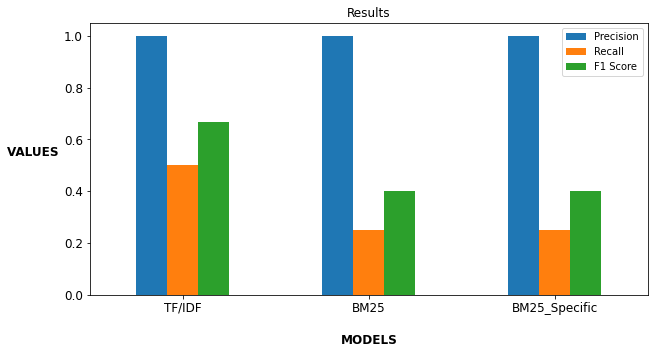

In [23]:
ax = Results[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', title ="Results", figsize=(10, 5), legend=True, fontsize=12)
ax.set_xlabel("\nMODELS", weight = 'bold', fontsize=12)
ax.set_ylabel("\nVALUES             ", weight = 'bold', rotation=0, fontsize=12)
ax.set_xticklabels(Results.columns, rotation=0)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'TF/IDF'
labels[1] = 'BM25'
labels[2] = 'BM25_Specific'
ax.set_xticklabels(labels)
plt.show()

In [24]:
#Example query input
inp = input("Retrieve a list of Scientific research papers about COVID-19 based on the query you input.\nPlease enter your Query: \n")
query = inp

q_terms = query.split()
q_terms

Retrieve a list of Scientific research papers about COVID-19 based on the query you input.
Please enter your Query: 
 virus


['virus']